# Version 1


-Implemented a simple Linear Regression model as the baseline.

-Logged the experiment using MLflow to track performance.

-Recorded MSE (Mean Squared Error), RMSE (Root Mean Squared Error), and R² Score as evaluation metrics.

-No data preprocessing was applied, so all raw data was used.

-Plots were created to analyze the initial distribution of residuals and the relationship between actual and predicted prices.

Train RMSE (log scale): 0.06743442547438248
Test RMSE (log scale): 0.06635528630538022
MSE: 281494.37, RMSE: 530.56, R²: 0.9694


2025/03/16 03:03:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


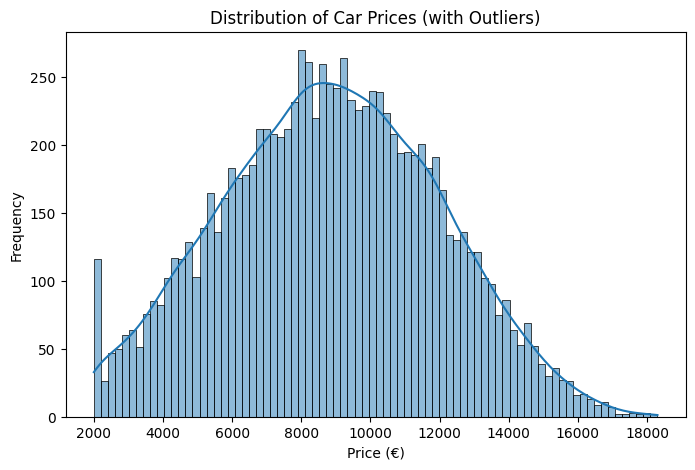

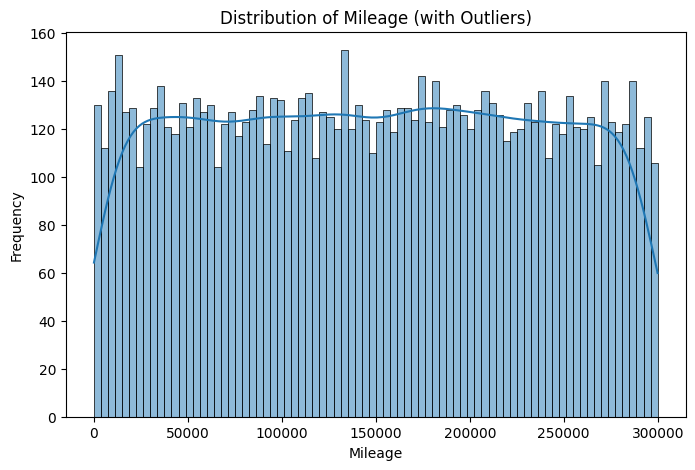

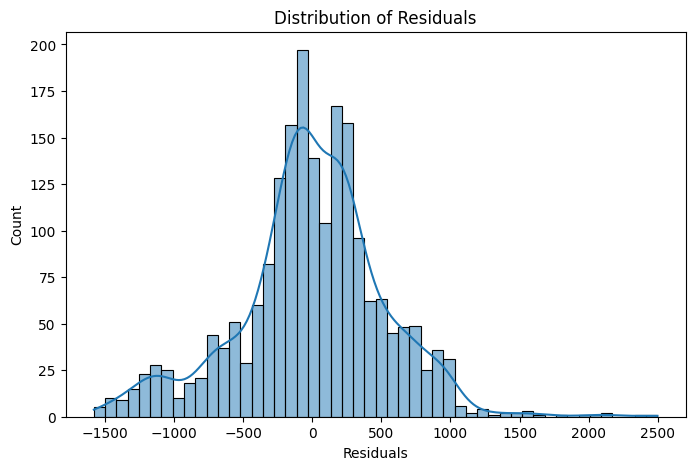

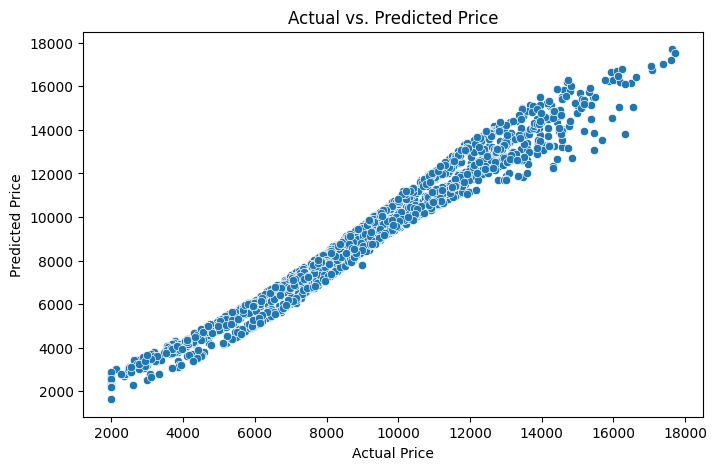

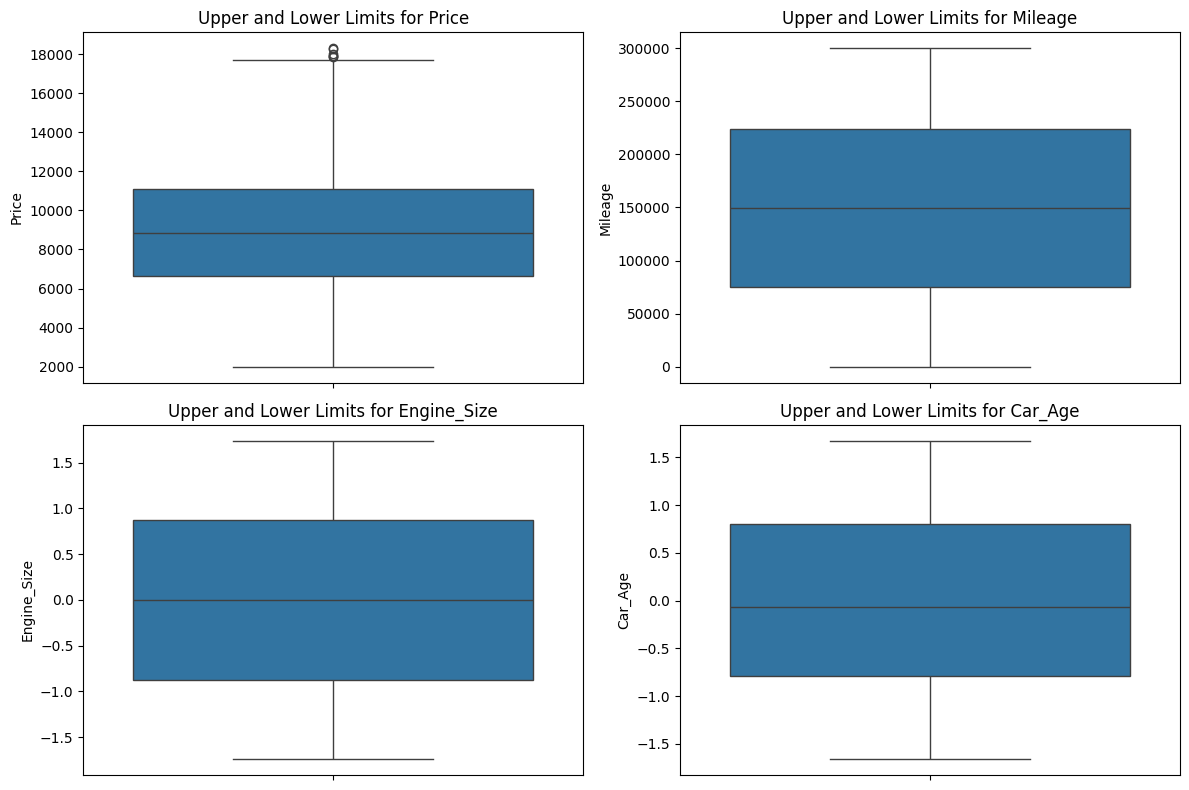

✅ MLflow Run completed!


In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Start MLflow experiment
mlflow.set_experiment("Car Price Prediction - Version 1")

with mlflow.start_run():
    # Load data
    df = pd.read_csv("car_price_dataset.csv")

    # Label encoding for categorical features
    categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature engineering
    df["Mileage_log"] = np.sqrt(df["Mileage"])  # Square root instead of log
    df["Car_Age"] = 2025 - df["Year"]  # Calculate car age

    # No removal of unrealistic values! (Will be done in version 2)

    # Standardize numerical features
    numeric_features = ["Engine_Size", "Mileage_log", "Car_Age", "Doors"]
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Log transformation of the target variable (price)
    df["Log_Price"] = np.log1p(df["Price"])

    # Split data into training & test sets
    X = df.drop(columns=["Price", "Log_Price"])  # Keep all features
    y = df["Log_Price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Pipeline with polynomial features and ridge regression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=1.0))
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_log = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Back transformation to actual prices

    # Evaluate model
    mse = mean_squared_error(np.expm1(y_test), y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(np.expm1(y_test), y_pred)

    # Compute training predictions using the pipeline
    y_train_pred_log = pipeline.predict(X_train)
    train_rmse_log = root_mean_squared_error(y_train, y_train_pred_log)

    # Compute test predictions using the pipeline
    y_test_pred_log = pipeline.predict(X_test)
    test_rmse_log = root_mean_squared_error(y_test, y_test_pred_log)

    print("Train RMSE (log scale):", train_rmse_log)
    print("Test RMSE (log scale):", test_rmse_log)

    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

    # MLflow Logging
    mlflow.log_param("poly_degree", 2)
    mlflow.log_param("ridge_alpha", 1.0)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)
    mlflow.sklearn.log_model(pipeline, "model")

    # Plot data distribution (Price)
    plt.figure(figsize=(8, 5))
    sns.histplot(df["Price"], bins=80, kde=True)
    plt.xlabel("Price (€)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Car Prices (with Outliers)")
    plt.savefig("price_distribution_v1.png")
    mlflow.log_artifact("price_distribution_v1.png")
    plt.show()

    # Plot data distribution (Mileage)
    plt.figure(figsize=(8, 5))
    sns.histplot(df["Mileage"], bins=80, kde=True)
    plt.xlabel("Mileage")
    plt.ylabel("Frequency")
    plt.title("Distribution of Mileage (with Outliers)")
    plt.savefig("mileage_distribution_v1.png")
    mlflow.log_artifact("mileage_distribution_v1.png")
    plt.show()

    # Plot residuals
    plt.figure(figsize=(8, 5))
    sns.histplot(np.expm1(y_test) - y_pred, bins=50, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Count")
    plt.title("Distribution of Residuals")
    plt.savefig("residuals_v1.png")
    mlflow.log_artifact("residuals_v1.png")
    plt.show()

    # Actual vs. Predicted Prices
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=np.expm1(y_test), y=y_pred)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title("Actual vs. Predicted Price")
    plt.savefig("actual_vs_predicted_v1.png")
    mlflow.log_artifact("actual_vs_predicted_v1.png")
    plt.show()

# Boxplots for actual values (non-transformed data)
features_to_plot = ["Price", "Mileage", "Engine_Size", "Car_Age"]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Upper and Lower Limits for {feature}")

plt.tight_layout()
plt.show()

# Complete MLflow Run
print("✅ MLflow Run completed!")
